In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import numpy as np
plt.style.use('seaborn-dark')
import glob

## Functions to make radial profiles plots

In [3]:
# intergrate spaxels values for the inner and outer regions specifed by the min and max respectivily
def radial_intergration(df, radius_series_str, min, max):
    spaxels_lessthan_max_df = df[df[radius_series_str] <= max]
    spaxels_btwminmax_df = spaxels_lessthan_max_df[spaxels_lessthan_max_df[radius_series_str] >= min]
    return spaxels_btwminmax_df

# Bin spaxels into radial bins and compute the median
# calculates the sum of the inner(0.0-0.5 Reff) and outer(0.0-0.5 Reff) radius
def dataframe_reff_bin_med_dist(df, ydata0_series_str, ydata0err_series_str, bins):
    '''
    Drop nan values for a given series in a given dataframe generated from MM_fits script and bins the values into predetermined radial bins. 
    The function also provides dataframes of the spaxels of central and disk region by a predetermeined radii
    '''
    # Replace lower values of working with Age
    if ydata0_series_str == 'GYR_LW':
    # df = df.copy()
        df[df[ydata0_series_str] < 5.0] = np.nan
    # df.head()
    else:
        pass
    
    
    df.dropna(subset=[ydata0_series_str, ydata0err_series_str, 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)

    # Make central spaxels dataframe from Combo
    central_spaxels_df = radial_intergration(df=df, radius_series_str='R/REFF', min=0.0, max=0.5)
    outer_spaxels_df = radial_intergration(df=df, radius_series_str='R/REFF', min=0.5, max=1.5)


    # Read in radial data
    xdata0 = df['R/REFF']

    # Properties for raidal profile
    ydata0 = df[ydata0_series_str]
    ydata0_err = df[ydata0err_series_str] # property error


    ###### R/Reff
    # Bin xdata and ydata into even bins of R/Reff and take median value
    # bins = np.linspace(0, 2, 16)
    digitized = np.digitize(xdata0, bins)
    xdata0_reffbin_meds = [xdata0[digitized == i].median() for i in range(1, len(bins))]
    ydata0_reffbin_meds = [ydata0[digitized == i].median() for i in range(1, len(bins))]

    # Error binning into even bins of R/Reff
    ydata0_err_reffbin_meds = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]

    return xdata0, ydata0, ydata0_err, xdata0_reffbin_meds, ydata0_reffbin_meds, ydata0_err_reffbin_meds, central_spaxels_df, outer_spaxels_df

def df_reff_bin_mean_dist(df, xdata0_series_str, ydata0_series_str, ydata0err_series_str, bins):
    '''
    Drop nan values for a given series in a given dataframe generated from MM_fits script and bins the values into predetermined radial bins. 
    The function also provides dataframes of the spaxels of central and disk region by a predetermeined radii
    '''
    # Replace lower values of working with Age
    if ydata0_series_str == 'GYR_LW':
    # df = df.copy()
        df[df[ydata0_series_str] < 8.5] = np.nan
    # df.head()
    else:
        pass
    
    
    df.dropna(subset=[xdata0_series_str, ydata0_series_str, ydata0err_series_str, 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)

    # # Make central spaxels dataframe from Combo
    # central_spaxels_df = radial_intergration(df=df, radius_series_str=xdata0_series_str, min=0.0, max=0.5)
    # outer_spaxels_df = radial_intergration(df=df, radius_series_str=xdata0_series_str, min=0.5, max=1.5)


    # Read in radial data
    xdata0 = df[xdata0_series_str]

    # Properties for raidal profile
    ydata0 = df[ydata0_series_str]
    ydata0_err = df[ydata0err_series_str] # property error


    ###### R/Reff
    # Bin xdata and ydata into even bins of R/Reff and take median value
    # bins = np.linspace(0, 2, 16)
    digitized = np.digitize(xdata0, bins)
    xdata0_binned_mean = [xdata0[digitized == i].max() for i in range(1, len(bins))]
    ydata0_binned_mean = [ydata0[digitized == i].mean() for i in range(1, len(bins))]
    nonan_orig_df = df.copy()

    # Error binning into even bins of R/Reff
    ydata0_err_binned_mean = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]
    return xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, nonan_orig_df #, central_spaxels_df, outer_spaxels_df

    # test function
    # xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(df, xdata0_series_str, ydata0_series_str, ydata0err_series_str, bins)


# Apply weights to each gaalxies in a radial bin based on the number of spaxels
# Then takes the average of the bins
def weighted_avg_binning(xdata_str, ydata_str, bins, csv_file_list):

    # Create a new CSV file to store the BreakBRd weights
    bbrd_weight_df = pd.DataFrame()
    # Create a CSV to store all the weights and averages of a bin for each galaxy
    bbrd_weighted_avgs_df = pd.DataFrame()

    for csv_file_path in csv_file_list:
        # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
        if (csv_file_path == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/9183-3703_map.csv"
            or csv_file_path == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/11827-1902_map.csv"
            or csv_file_path == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/8595-3703_map.csv"
            ):
            pass
        
        else:
            # print(csv_file_path)
            bbrd_df = pd.read_csv(csv_file_path)
                # Replace bad age values
            if ydata_str == 'GYR_LW':
            # df = df.copy()
                bbrd_df[bbrd_df[ydata_str] < 5.0] = np.nan
            # df.head()
            else:
                pass
            
            # Copy the combo csv to drop nan values but keep the combo_df from changing
            bbrd_combo_cp_df = bbrd_df.copy()
            bbrd_combo_cp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
            bbrd_combo_cp_df.dropna(subset=[xdata_str, ydata_str, 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)
            
            # Read in x and y data
            xdata = bbrd_combo_cp_df[xdata_str]
            ydata = bbrd_combo_cp_df[ydata_str]

            # remove inf values from ydata
            

            # Start binning
            digitized = np.digitize(xdata, bins)

            # Interate through each file to collect the total number of spaxels from each gaalxy in each in bin (the weight of each galaxy in a bin)
            #     # Create a new CSV file to store the BreakBRd weights
            # bbrd_weight_df = pd.DataFrame()
            # # Create a CSV to store all the weights and averages of a bin for each galaxy
            # bbrd_weighted_avgs_df = pd.DataFrame()

            # Empty list to store weights  and weights*avg values
            ydata_bin_weight = []
            ydata_w_avg_per_bin = []
            # count = np.isinf(ydata).values.sum()
            # print("It contains " + str(count) + " infinite values")
            for i in range(1, len(bins)):
                
                ydata_bin_spax = ydata[digitized == i]
                ydata_bin_weight.append(len(ydata_bin_spax))
                # print(np.mean(ydata_bin_spax), len(ydata_bin_spax))
                ydata_w_avg_per_bin.append(np.mean(ydata_bin_spax) * len(ydata_bin_spax))
                
            # Appends weights to a dataframe
            bbrd_weight_df[csv_file_path[-19:]] = ydata_bin_weight
            bbrd_weighted_avgs_df[csv_file_path[-19:]] = ydata_w_avg_per_bin

    # Adds the total number of spaxels in a bin (Denominator)
    bbrd_weight_df['Total # spaxels in bin'] = bbrd_weight_df.sum(axis=1)
    # Sums of all the weights (Numerator)
    # bbrd_weighted_avgs_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    bbrd_weighted_avgs_df['Sum of w*avg in bin'] = bbrd_weighted_avgs_df.sum(axis=1)
    # weighted_average radial profile
    bbrd_ydata_w_avgs = bbrd_weighted_avgs_df['Sum of w*avg in bin'] / bbrd_weight_df['Total # spaxels in bin']
    xdata_bin_spax = [xdata[digitized == i].max() for i in range(1, len(bins))]

    return xdata_bin_spax, bbrd_ydata_w_avgs, bbrd_weight_df, bbrd_weighted_avgs_df

## Test function
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str='R/REFF', ydata_str='LOGSFR DENSITY', bins=np.linspace(0, 1.8, 12), csv_file_list=lg12_csv_list)
# lg12_weighted_avgs_df.head(14)

# Read lg12 and bbrd map csv and super_csv files

In [4]:
# # Set paths for csv and supercsv
# super_csv_dir_path = ''
# bbrd_csv_maps_path = '/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/'
# lg12_csv_maps_path = '/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/'

# Read super csv as dataframes
bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv')
lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv')
lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv')


# List of csv files  that made super_csv
bbrd_csv_list = glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv')
lg12_csv_list = glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv')

In [6]:
# # Dn4000 radial profiles settings
# # Set variables
# bbrd_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv') 
# lg12_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv')
# bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv')
# lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv')
# lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv')
# ydata_str = 'DAP_DN4000'
# yerr_str = 'DAP_DN4000_IVAR'
# reff_bins = np.linspace(0.01, 2.0, 11)
# rellip_bins = np.linspace(0, 10, 11)
# cen_min = 0.0
# cen_max = 0.5
# out_min = 0.51
# out_max = 2.0
# x_reff_str='R/REFF' 
# x_rellip_str='R_KPC' 
# show_corot=False 
# co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703']
# bbrd_radpro_color = 'teal'
# lg12_sf_radpro_color = 'grey'
# lg12_qc_radpro_color = 'darkred'
# reff_xlim = (0.0, 2.2)
# rellip_xlim = (0.0,  10.5)
# ydata_lim = (0.3, 2.0)
# reff_label = r'$R/R_{eff}$'
# ydata_label = r'$D_{n}4000$'
# bbrd_fw_avg_color = 'magenta'
# lg12_sf_fw_avg_color = 'navy'
# lg12_qc_fw_avg_color = 'darkred'
# co_rot_color = 'orange'
# kde_prod_den_lim = (0.0, 5.0)
# dist_bins = 20
# kde_clip_lim = (0.0, 5.0)
# saveplot_filepath = '/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_bbrd_lg12_subplot.pdf'

# ################################################################################################
# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# bbrd_sf_xdata_bin_spax, bbrd_sf_ydata_w_avgs, bbrd_sf_weight_df, bbrd_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=bbrd_csv_list)

# # Apply REFF radial binning function to super_csv files
# bbrd_sf_xdata0, bbrd_sf_ydata0, bbrd_sf_ydata0_err, bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, bbrd_sf_ydata0_err_binned_mean, bbrd_sf_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# bbrd_sf_rellip_xdata0, bbrd_sf_rellip_ydata0, bbrd_sf_rellip_ydata0_err, bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, bbrd_sf_rellip_ydata0_err_binned_mean, bbrd_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# bbrd_sf_central_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
# bbrd_sf_outer_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
# bbrd_sf_central_mean = np.mean(bbrd_sf_central_spax_df[ydata_str])
# bbrd_sf_outer_mean = np.mean(bbrd_sf_outer_spax_df[ydata_str])

# ################################ SF sample

# # LG12 complete smaple DN4000 weighted Average radial profile (reff)
# lg12_sf_xdata_bin_spax, lg12_sf_ydata_w_avgs, lg12_sf_weight_df, lg12_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


# # Apply REFF radial binning function to super_csv files
# lg12_sf_xdata0, lg12_sf_ydata0, lg12_sf_ydata0_err, lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, lg12_sf_ydata0_err_binned_mean, lg12_sf_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 

# # Apply RELLIP radial binning function to super_csv files
# lg12_sf_rellip_xdata0, lg12_sf_rellip_ydata0, lg12_sf_rellip_ydata0_err, lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, lg12_sf_rellip_ydata0_err_binned_mean, lg12_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_sf_central_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
# lg12_sf_outer_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
# lg12_sf_central_mean = np.mean(lg12_sf_central_spax_df[ydata_str])
# lg12_sf_outer_mean = np.mean(lg12_sf_outer_spax_df[ydata_str])


# ################################ QC sample 
# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# lg12_qc_xdata_bin_spax, lg12_qc_ydata_w_avgs, lg12_qc_weight_df, lg12_qc_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)

# # Apply REFF radial binning function to super_csv files
# lg12_qc_xdata0, lg12_qc_ydata0, lg12_qc_ydata0_err, lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, lg12_qc_ydata0_err_binned_mean, lg12_qc_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# lg12_qc_rellip_xdata0, lg12_qc_rellip_ydata0, lg12_qc_rellip_ydata0_err, lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, lg12_qc_rellip_ydata0_err_binned_mean, lg12_qc_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_qc_central_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
# lg12_qc_outer_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
# lg12_qc_central_mean = np.mean(lg12_qc_central_spax_df[ydata_str])
# lg12_qc_outer_mean = np.mean(lg12_qc_outer_spax_df[ydata_str])

Plotting SF LG12 sample
Plotting QC LG12 sample
Plotting SF BBRD sample


/Users/mmckay/conda/envs/marvin_v2/lib/python3.6/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


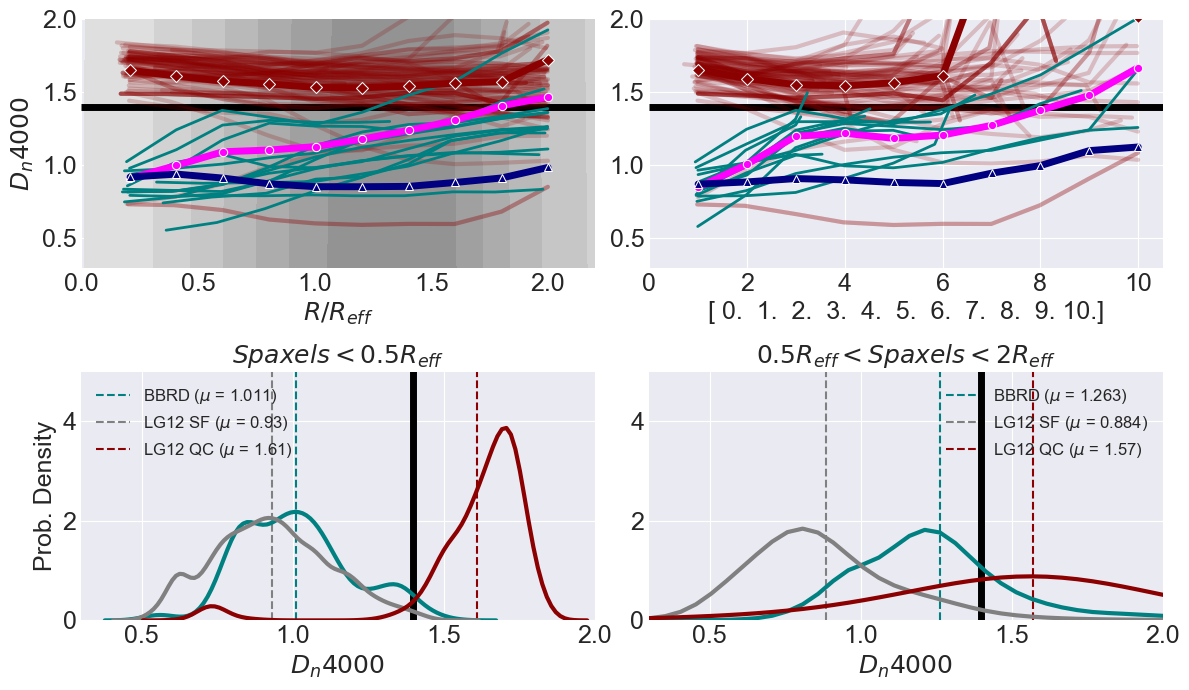

In [12]:
# ##############################################################################################################################################################################
# # Subplot
# fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(12,7), constrained_layout=False, dpi=100, sharey=False)

# # SF galaxies using fiber Dn4000 < 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# ###############################################################################################################
# print('Plotting SF LG12 sample')
# sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/sf_lg12_global_df.csv')
# # for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
# #     lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
# #     sf_lg12_copy_df = lg12_sf_df.copy()
# #     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# #     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=lg12_sf_radpro_color, alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(sf_lg12_copy_df)))
# #     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins)
# #     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=lg12_sf_radpro_color, alpha=0.2, legend=False, linewidth=3)

# # QC galaxies using fiber Dn4000 > 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
    
# print('Plotting QC LG12 sample')
# qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/qc_lg12_global_df.csv')
# for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
#     lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
#     qc_lg12_copy_df = lg12_qc_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=lg12_qc_radpro_color, alpha=0.2, legend=False, linewidth=3, label='LG12 QC {}'.format(len(lg12_qc_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=lg12_qc_radpro_color, alpha=0.2, legend=False, linewidth=3)

# # Plot all BBRD csv list
# print('Plotting SF BBRD sample')
# for bbrd_csv in bbrd_csv_list:
#     # Remove AGN and Merger galaxies 
#     # if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
#     #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11827-1902_map.csv"
#     #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8595-3703_map.csv"
#     #     ):
#     #     pass
    
#     # highlight co-rotators
#     if show_corot==True:
#         print('Plotting co-rotators')
#         for co_plateifu in co_plateifu_list:
#             if bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/{}_map.csv".format(co_plateifu):
#                 bbrd_df = pd.read_csv(bbrd_csv)
#                 bbrd_copy_df = bbrd_df.copy()
#                 xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#                 sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, marker="o", color=co_rot_color, alpha=1, legend=False, linewidth=2)
#                 xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#                 sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, marker="o", color=co_rot_color, alpha=1, legend=False, linewidth=2)
#             else:
#                 pass
#     else:
#         pass
#     # print(bbrd_csv)
#     bbrd_df = pd.read_csv(bbrd_csv)
#     bbrd_copy_df = bbrd_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=bbrd_radpro_color, alpha=1, legend=False, linewidth=2)
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=bbrd_radpro_color, alpha=1, legend=False, linewidth=2)

# # KDE
# sns.kdeplot(lg12_sf_xdata0, lg12_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color='grey', label=r'All DAP $D_{n}4000$')


# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, ax=ax0, marker="o", color=bbrd_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, ax=ax0, marker="^", color=lg12_sf_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, ax=ax0, marker="D", color=lg12_qc_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample


# # sns.kdeplot(bbrd_sf_xdata0, bbrd_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color=bbrd_radpro_color, label='(#{}) BreakBRD spaxels'.format(len(bbrd_sf_ydata0)), levels=30)
# ax0.hlines(1.4, 0, 3, color='black', linewidth=5, linestyles='-')
# ax0.grid(True)
# ax0.set_xlim(reff_xlim)
# ax0.set_ylim(ydata_lim)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(reff_label, fontsize=18)
# ax0.set_ylabel(ydata_label, fontsize=18)
# # ax0.legend(ncol=1, fontsize=12, loc='lower left')



# ###############################################################################################################
# # Ax1
# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, ax=ax1, marker="o", color=bbrd_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, ax=ax1, marker="^", color=lg12_sf_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, ax=ax1, marker="D", color=lg12_qc_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample
# ax1.hlines(1.4, 0, 15, color='black', linewidth=5, linestyles='-')
# ax1.grid(True)
# ax1.set_xlim(rellip_xlim)
# ax1.set_ylim(ydata_lim)
# ax1.set_xlabel(rellip_bins, fontsize=18)
# ax1.tick_params(axis='x', labelsize=18)
# ax1.tick_params(axis='y', labelsize=18)

# ###############################################################################################################
# # AX2
# # BBRD SF sample
# sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": bbrd_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)
# # LG12 SF
# sns.distplot(lg12_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": lg12_sf_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)
# # LG12 QC
# sns.distplot(lg12_qc_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": lg12_qc_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)

# # Mean vertical line
# ax2.vlines(np.mean(bbrd_sf_central_spax_df[ydata_str]), 0, 5.0, color=bbrd_radpro_color, alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_central_mean, 3)))
# ax2.vlines(np.mean(lg12_sf_central_spax_df[ydata_str]), 0, 5.0, color=lg12_sf_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_central_mean, 3)))
# ax2.vlines(np.mean(lg12_qc_central_spax_df[ydata_str]), 0, 5.0, color=lg12_qc_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_central_mean, 3)))
# ax2.vlines(1.4, 0, 8, color='black', linewidth=5)
# ax2.legend(fontsize=12, ncol=1)


# ax2.grid(True)
# ax2.set_xlim(ydata_lim)
# ax2.set_ylim(kde_prod_den_lim)
# ax2.set_xlabel(ydata_label, fontsize=18)
# ax2.set_ylabel('Prob. Density', fontsize=18)
# ax2.set_title(r'$Spaxels < 0.5 R_{eff}$', fontsize=18)
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)
# ax2.legend(fontsize=12, ncol=1)

# ###############################################################################################################
# # Ax3 outer spaxel dist
# # bbrd sf
# sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": bbrd_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)
# # lg12 sf
# sns.distplot(lg12_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": lg12_sf_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)
# # lg12 qc
# sns.distplot(lg12_qc_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": lg12_qc_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)

# # Mean vertical line
# ax3.vlines(np.mean(bbrd_sf_outer_spax_df[ydata_str]), 0, 5.0, color=bbrd_radpro_color, alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_outer_mean, 3)))
# ax3.vlines(np.mean(lg12_sf_outer_spax_df[ydata_str]), 0, 5.0, color=lg12_sf_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_outer_mean, 3)))
# ax3.vlines(np.mean(lg12_qc_outer_spax_df[ydata_str]), 0, 5.0, color=lg12_qc_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_outer_mean, 3)))
# ax3.vlines(1.4, 0, 8, color='black', linewidth=5)
# ax3.legend(fontsize=12, loc='upper right', ncol=1)



# ax3.grid(True)
# ax3.set_xlim(ydata_lim)
# ax3.set_ylim(kde_prod_den_lim)
# ax3.set_xlabel(ydata_label, fontsize=18)
# ax3.set_title(r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$', fontsize=18)
# ax3.tick_params(axis='x', labelsize=18)
# ax3.tick_params(axis='y', labelsize=18)




# plt.tight_layout()
# plt.savefig(saveplot_filepath, dpi=300)

# **<span style='color:Pink'> Dn4000 radial profiles </span>**
*** 

In [15]:
# Assign the x and y variables with the series column name as a str
x_reff_str = 'R/REFF'
x_rellip_str = 'R_KPC'
ydata_str = 'DAP_DN4000'
yerr_str = 'DAP_DN4000_IVAR'
reff_bins = np.linspace(0.01, 2.2, 11)
rellip_bins = np.linspace(0, 10, 11)

# BBRD complete smaple DN4000 weighted Average radial profile (reff)
bbrd_sf_xdata_bin_spax, bbrd_sf_ydata_w_avgs, bbrd_sf_weight_df, bbrd_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=bbrd_csv_list)

# Apply REFF radial binning function to super_csv files
bbrd_sf_xdata0, bbrd_sf_ydata0, bbrd_sf_ydata0_err, bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, bbrd_sf_ydata0_err_binned_mean, bbrd_sf_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# Apply RELLIP radial binning function to super_csv files
bbrd_sf_rellip_xdata0, bbrd_sf_rellip_ydata0, bbrd_sf_rellip_ydata0_err, bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, bbrd_sf_rellip_ydata0_err_binned_mean, bbrd_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# Radial intergration
bbrd_sf_central_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
bbrd_sf_outer_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
bbrd_sf_central_mean = np.mean(bbrd_sf_central_spax_df[ydata_str])
bbrd_sf_outer_mean = np.mean(bbrd_sf_outer_spax_df[ydata_str])



################################ SF sample ################################

# LG12 complete smaple DN4000 weighted Average radial profile (reff)
lg12_sf_xdata_bin_spax, lg12_sf_ydata_w_avgs, lg12_sf_weight_df, lg12_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


# Apply REFF radial binning function to super_csv files
lg12_sf_xdata0, lg12_sf_ydata0, lg12_sf_ydata0_err, lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, lg12_sf_ydata0_err_binned_mean, lg12_sf_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 

# Apply RELLIP radial binning function to super_csv files
lg12_sf_rellip_xdata0, lg12_sf_rellip_ydata0, lg12_sf_rellip_ydata0_err, lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, lg12_sf_rellip_ydata0_err_binned_mean, lg12_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# Radial intergration
lg12_sf_central_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
lg12_sf_outer_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
lg12_sf_central_mean = np.mean(lg12_sf_central_spax_df[ydata_str])
lg12_sf_outer_mean = np.mean(lg12_sf_outer_spax_df[ydata_str])


################################ QC sample ################################
# BBRD complete smaple DN4000 weighted Average radial profile (reff)
lg12_qc_xdata_bin_spax, lg12_qc_ydata_w_avgs, lg12_qc_weight_df, lg12_qc_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)

# Apply REFF radial binning function to super_csv files
lg12_qc_xdata0, lg12_qc_ydata0, lg12_qc_ydata0_err, lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, lg12_qc_ydata0_err_binned_mean, lg12_qc_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# Apply RELLIP radial binning function to super_csv files
lg12_qc_rellip_xdata0, lg12_qc_rellip_ydata0, lg12_qc_rellip_ydata0_err, lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, lg12_qc_rellip_ydata0_err_binned_mean, lg12_qc_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# Radial intergration
lg12_qc_central_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
lg12_qc_outer_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
lg12_qc_central_mean = np.mean(lg12_qc_central_spax_df[ydata_str])
lg12_qc_outer_mean = np.mean(lg12_qc_outer_spax_df[ydata_str])



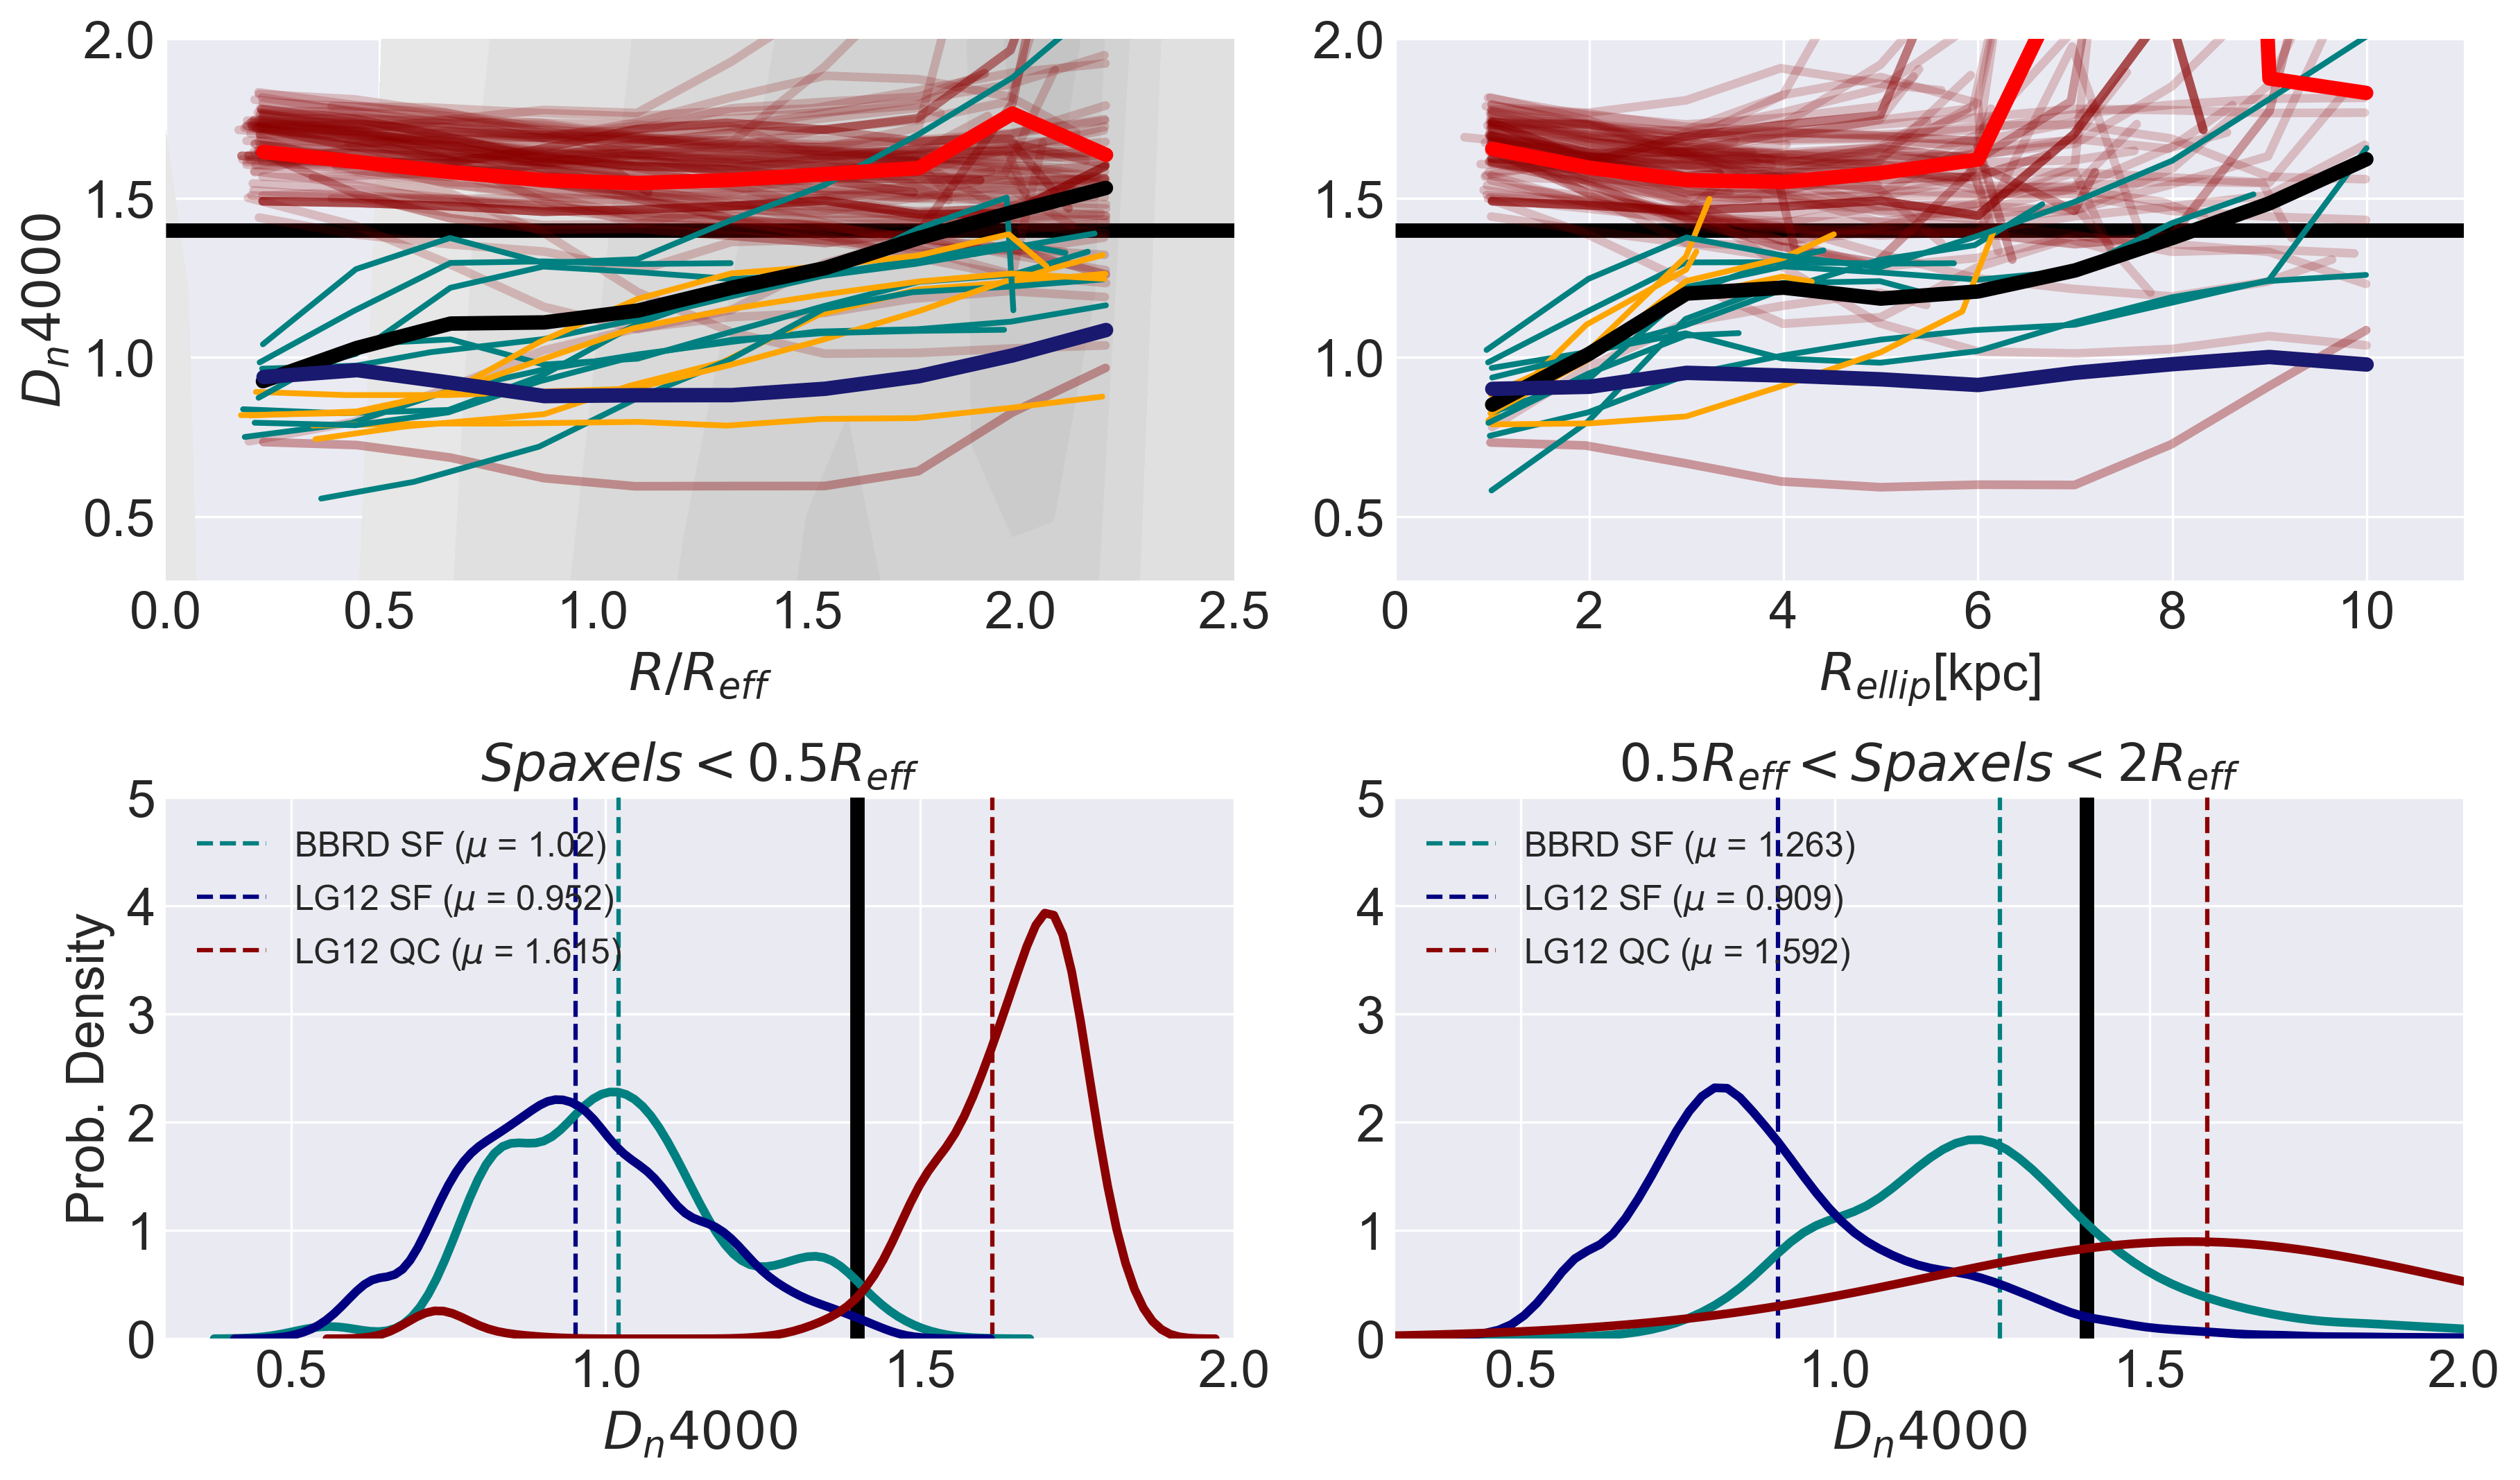

In [24]:
show_corot=True
agn_merger=True

# Subplot
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(12,7), constrained_layout=True, dpi=300, sharey=False)

# SF galaxies using fiber Dn4000 < 1.5
# # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/sf_lg12_global_df.csv')
# for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
#     lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
#     sf_lg12_copy_df = lg12_sf_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_sf_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3)

# SF galaxies using fiber Dn4000 < 1.5
# # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/qc_lg12_global_df.csv')
for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
    lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
    qc_lg12_copy_df = lg12_qc_df.copy()
    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='darkred', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_qc_df)))
    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='darkred', alpha=0.2, legend=False, linewidth=3)



# Plot all csv list
for bbrd_csv in bbrd_csv_list:
    # Remove AGN and Merger galaxies 
    if agn_merger==True and (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11827-1902_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8595-3703_map.csv"
        ):
        pass


    # highlight co-rotators
    if show_corot==True and (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8254-1902_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/10001-3702_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11760-1902_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11758-1901_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
        ):
        bbrd_df = pd.read_csv(bbrd_csv)
        bbrd_copy_df = bbrd_df.copy()
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='orange', alpha=1, legend=False, linewidth=2)
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='orange', alpha=1, legend=False, linewidth=2)

    
    else:
        # print(bbrd_csv)
        bbrd_df = pd.read_csv(bbrd_csv)
        bbrd_copy_df = bbrd_df.copy()
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='teal', alpha=1, legend=False, linewidth=2)
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='teal', alpha=1, legend=False, linewidth=2)


# Plot frequency weighted median
sns.lineplot(bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, ax=ax0, color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
sns.lineplot(lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, ax=ax0, color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
sns.lineplot(lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, ax=ax0, color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample


sns.kdeplot(lg12_sf_xdata0, lg12_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color='grey', label=r'All DAP $D_{n}4000$', legend=False, levels=15)

# Axes
ax0.hlines(1.4, 0, 3, color='black', linewidth=5, linestyles='-')
ax0.grid(True)
ax0.set_xlim(0.0, 2.5)
ax0.set_ylim(0.3, 2.0)
ax0.tick_params(axis='x', labelsize=18)
ax0.tick_params(axis='y', labelsize=18)
ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
ax0.set_ylabel(r'$D_{n}4000$', fontsize=18)
# ax0.legend(ncol=1, fontsize=12, loc='lower left')




# Ax1
# Plot frequency weighted median
sns.lineplot(bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, ax=ax1, color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
sns.lineplot(lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, ax=ax1, color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
sns.lineplot(lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, ax=ax1, color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

ax1.hlines(1.4, 0, 15, color='black', linewidth=5, linestyles='-')
ax1.grid(True)
ax1.set_xlim(0.0, 11)
ax1.set_ylim(0.3, 2.0)
ax1.set_xlabel(r'$R_{ellip}$[kpc]', fontsize=18)

ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)


# AX2
# BBRD SF sample
# sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, hist=False, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, hist=False, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "teal", "lw": 3, "alpha":1.0, 'clip': (0.0, 2.0)}, hist=False, vertical=False)
ax2.vlines(np.mean(bbrd_sf_central_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'BBRD SF ($\mu$ = {})'.format(round(bbrd_sf_central_mean, 3)))

# LG12 SF
sns.distplot(lg12_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "navy", "lw": 3, "alpha":1.0, 'clip': (0.0, 2.0)}, hist=False, vertical=False)
ax2.vlines(np.mean(lg12_sf_central_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_central_mean, 3)))

# LG12 QC
sns.distplot(lg12_qc_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "darkred", "lw": 3, "alpha":1.0, 'clip': (0.0, 2.0)}, hist=False, vertical=False)
ax2.vlines(np.mean(lg12_qc_central_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_central_mean, 3)))


ax2.vlines(1.4, 0, 2000, color='black', linewidth=5)
ax2.grid(True)
ax2.set_xlim(0.3, 2.0)
ax2.set_ylim(0.0, 5.0)
ax2.set_xlabel(r'$D_{n}4000$', fontsize=18)
ax2.set_ylabel('Prob. Density', fontsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.legend(fontsize=12, loc='best', ncol=1)
ax2.set_title(r'$Spaxels < 0.5 R_{eff}$', fontsize=18)


# Ax3 outer spaxel dist
# bbrd sf
sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "teal", "lw": 3, "alpha":1.0, 'clip': (0.0, 2.0)}, hist=False, vertical=False)
ax3.vlines(np.mean(bbrd_sf_outer_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'BBRD SF ($\mu$ = {})'.format(round(bbrd_sf_outer_mean, 3)))

# lg12 sf
sns.distplot(lg12_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "navy", "lw": 3, "alpha":1.0, 'clip': (0.0, 2.0)}, hist=False, vertical=False)
ax3.vlines(np.mean(lg12_sf_outer_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_outer_mean, 3)))

# lg12 qc
sns.distplot(lg12_qc_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "darkred", "lw": 3, "alpha":1.0, 'clip': (0.0, 2.0)}, hist=False, vertical=False)
ax3.vlines(np.mean(lg12_qc_outer_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_outer_mean, 3)))


ax3.vlines(1.4, 0, 2000, color='black', linewidth=5)
ax3.grid(True)
ax3.set_xlim(0.3, 2.0)
ax3.set_ylim(0.0, 5.0)
ax3.set_xlabel(r'$D_{n}4000$', fontsize=18)
ax3.tick_params(axis='x', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)
ax3.legend(fontsize=12, loc='upper left', ncol=1)
ax3.set_title(r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$', fontsize=18)

plt.savefig('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_Dn4000cut_sf_qc_superdf/dn4000cut_Age_bbrd_lg12_subplot.pdf')

# **<span style='color:Red'> Luminosity-weighted Age </span>**


In [13]:
# Assign the x and y variables with the series column name as a str
x_reff_str = 'R/REFF'
x_rellip_str = 'R_KPC'
ydata_str = 'GYR_LW'
yerr_str = 'GYR_ERR'
reff_bins = np.linspace(0.01, 2.2, 11)
rellip_bins = np.linspace(0, 10, 11)

# BBRD complete smaple DN4000 weighted Average radial profile (reff)
bbrd_sf_xdata_bin_spax, bbrd_sf_ydata_w_avgs, bbrd_sf_weight_df, bbrd_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=bbrd_csv_list)

# Apply REFF radial binning function to super_csv files
bbrd_sf_xdata0, bbrd_sf_ydata0, bbrd_sf_ydata0_err, bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, bbrd_sf_ydata0_err_binned_mean, bbrd_sf_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# Apply RELLIP radial binning function to super_csv files
bbrd_sf_rellip_xdata0, bbrd_sf_rellip_ydata0, bbrd_sf_rellip_ydata0_err, bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, bbrd_sf_rellip_ydata0_err_binned_mean, bbrd_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# Radial intergration
bbrd_sf_central_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
bbrd_sf_outer_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
bbrd_sf_central_mean = np.mean(bbrd_sf_central_spax_df[ydata_str])
bbrd_sf_outer_mean = np.mean(bbrd_sf_outer_spax_df[ydata_str])



################################ SF sample

# LG12 complete smaple DN4000 weighted Average radial profile (reff)
lg12_sf_xdata_bin_spax, lg12_sf_ydata_w_avgs, lg12_sf_weight_df, lg12_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


# Apply REFF radial binning function to super_csv files
lg12_sf_xdata0, lg12_sf_ydata0, lg12_sf_ydata0_err, lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, lg12_sf_ydata0_err_binned_mean, lg12_sf_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 

# Apply RELLIP radial binning function to super_csv files
lg12_sf_rellip_xdata0, lg12_sf_rellip_ydata0, lg12_sf_rellip_ydata0_err, lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, lg12_sf_rellip_ydata0_err_binned_mean, lg12_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# Radial intergration
lg12_sf_central_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
lg12_sf_outer_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
lg12_sf_central_mean = np.mean(lg12_sf_central_spax_df[ydata_str])
lg12_sf_outer_mean = np.mean(lg12_sf_outer_spax_df[ydata_str])


################################ QC sample 
# BBRD complete smaple DN4000 weighted Average radial profile (reff)
lg12_qc_xdata_bin_spax, lg12_qc_ydata_w_avgs, lg12_qc_weight_df, lg12_qc_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)

# Apply REFF radial binning function to super_csv files
lg12_qc_xdata0, lg12_qc_ydata0, lg12_qc_ydata0_err, lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, lg12_qc_ydata0_err_binned_mean, lg12_qc_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# Apply RELLIP radial binning function to super_csv files
lg12_qc_rellip_xdata0, lg12_qc_rellip_ydata0, lg12_qc_rellip_ydata0_err, lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, lg12_qc_rellip_ydata0_err_binned_mean, lg12_qc_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# Radial intergration
lg12_qc_central_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
lg12_qc_outer_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
lg12_qc_central_mean = np.mean(lg12_qc_central_spax_df[ydata_str])
lg12_qc_outer_mean = np.mean(lg12_qc_outer_spax_df[ydata_str])



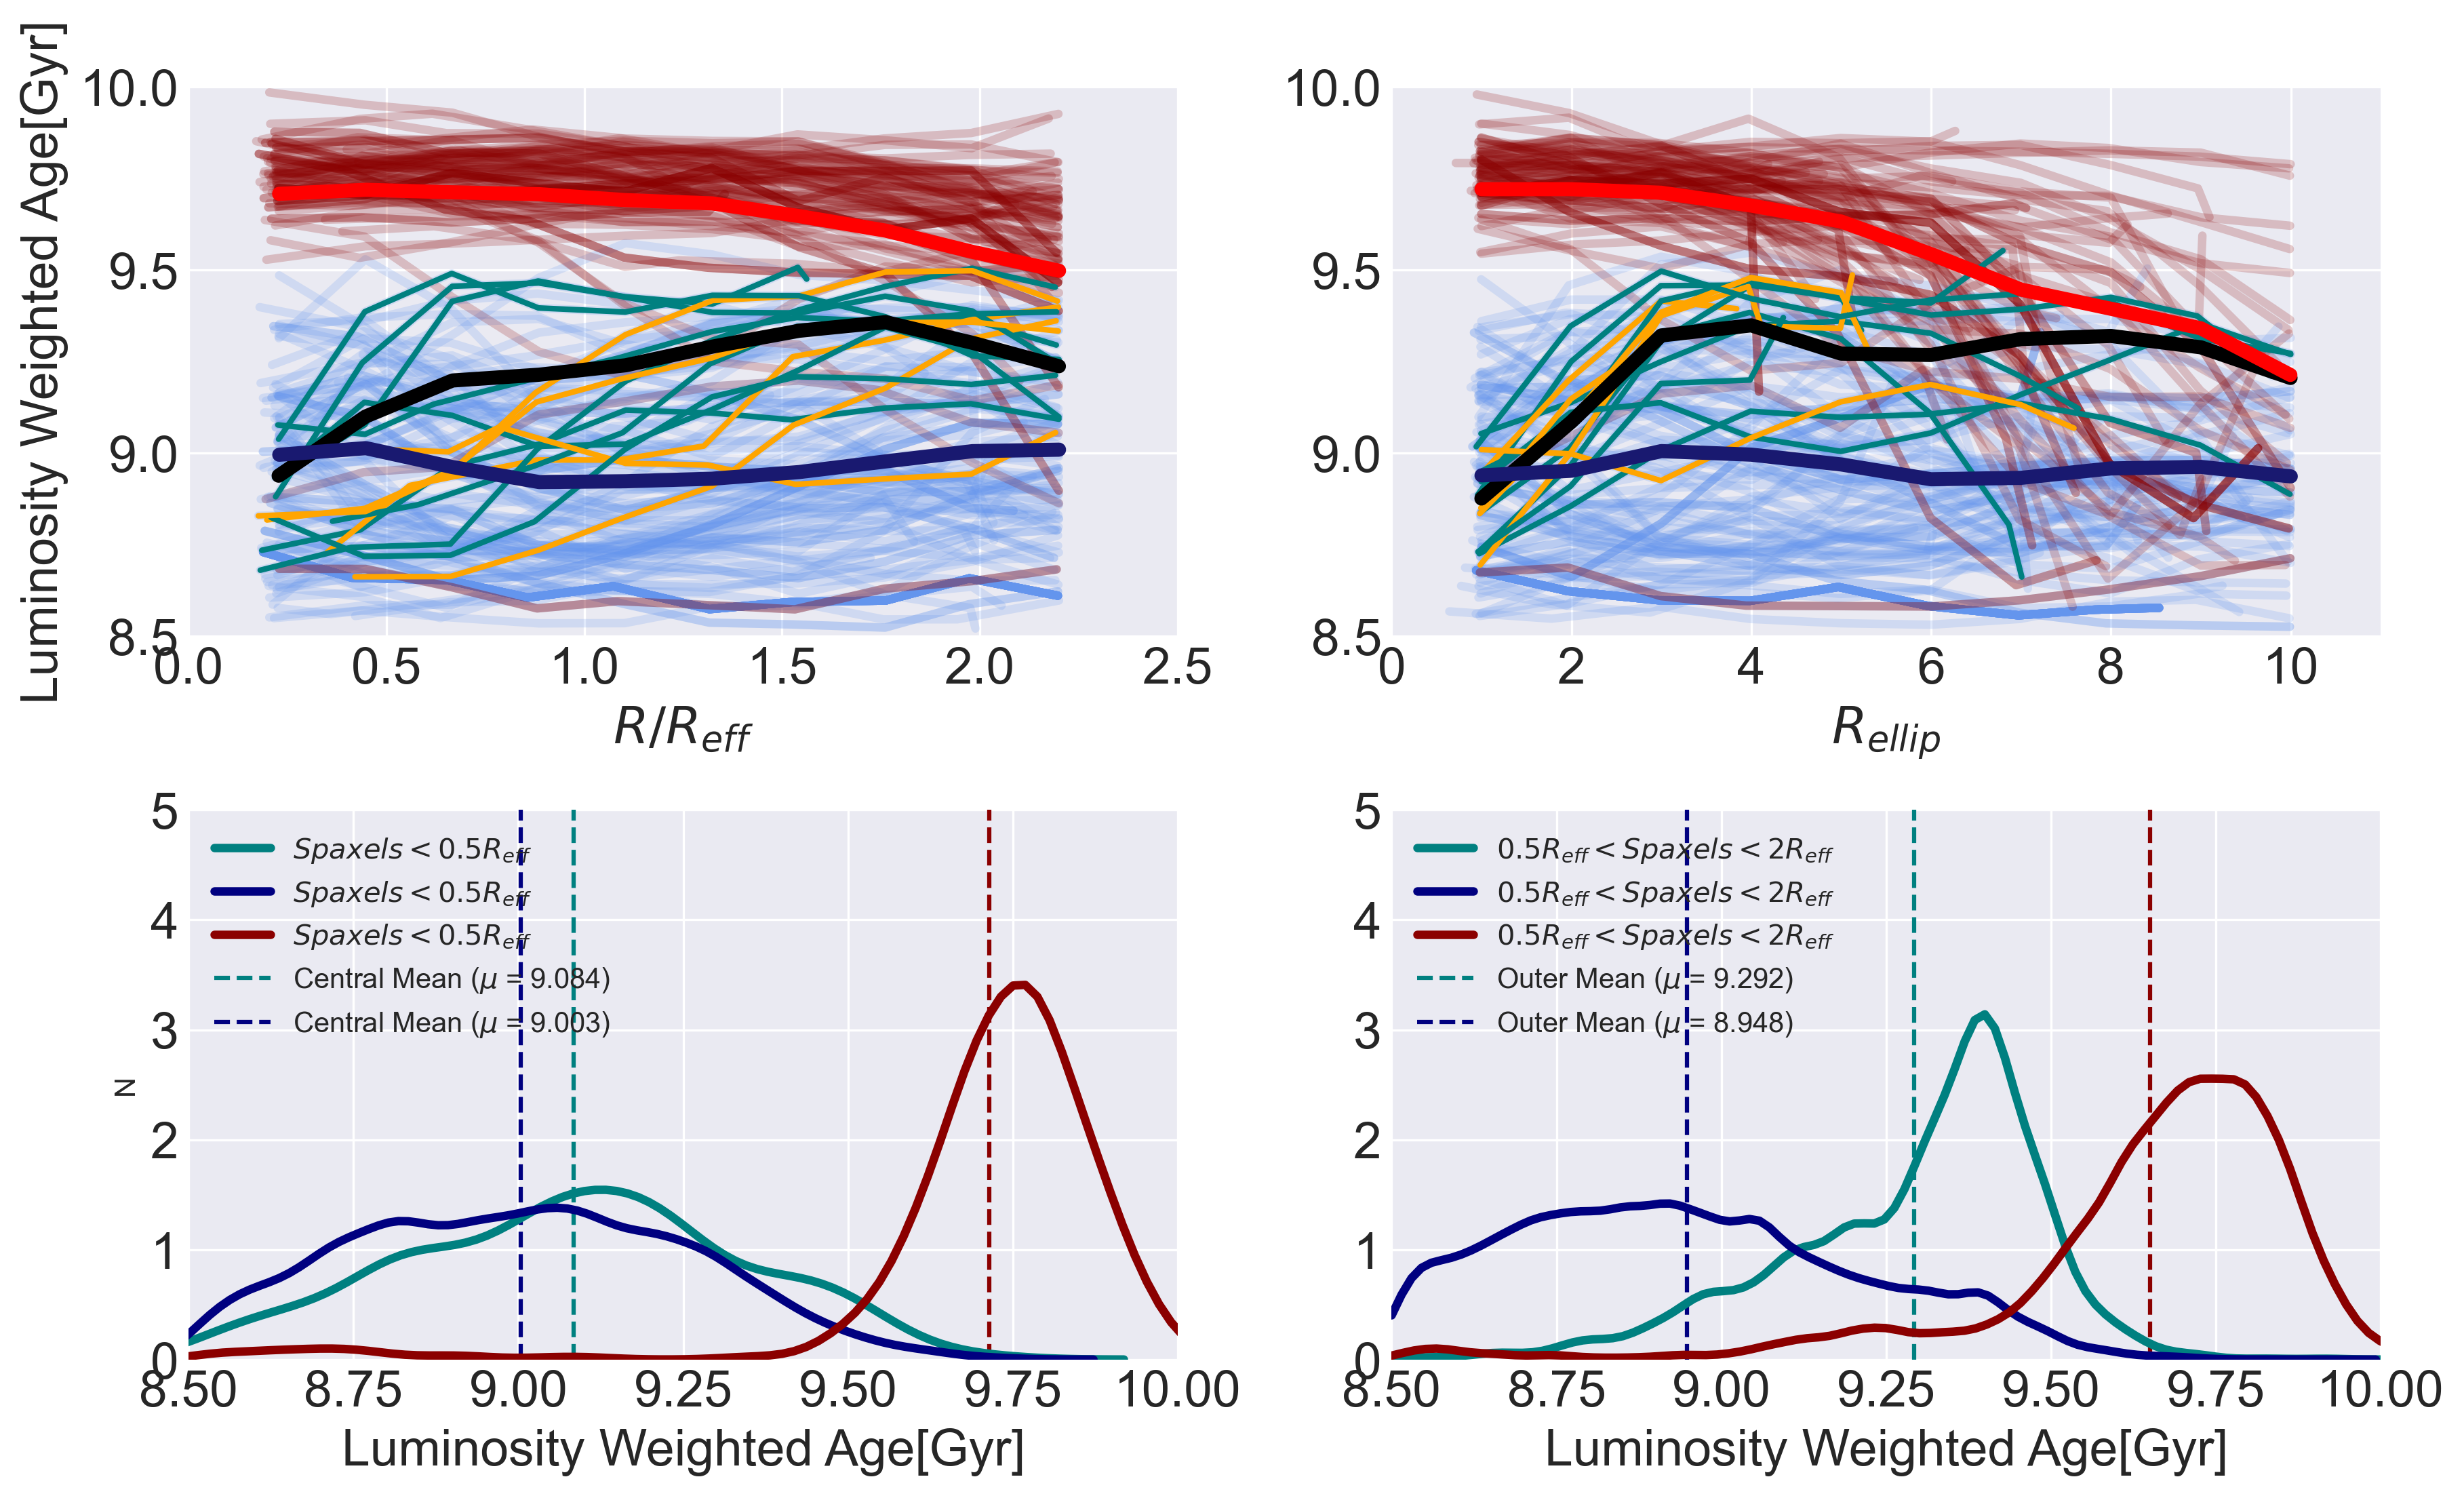

In [14]:
# Subplot
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(12,7), constrained_layout=True, dpi=300, sharey=False)


# SF galaxies using fiber Dn4000 < 1.5
# # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/sf_lg12_global_df.csv')
for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
    lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
    sf_lg12_copy_df = lg12_sf_df.copy()
    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_sf_df)))
    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3)

# SF galaxies using fiber Dn4000 < 1.5
# # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/qc_lg12_global_df.csv')
for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
    lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
    qc_lg12_copy_df = lg12_qc_df.copy()
    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='darkred', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_qc_df)))
    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='darkred', alpha=0.2, legend=False, linewidth=3)



# Plot all csv list
for bbrd_csv in bbrd_csv_list:
    # Remove AGN and Merger galaxies 
    # if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
    #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11827-1902_map.csv"
    #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8595-3703_map.csv"
    #     ):
    #     pass
    # highlight co-rotators
    if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8254-1902_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/10001-3702_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11760-1902_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11758-1901_map.csv"
        or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
        ):
        bbrd_df = pd.read_csv(bbrd_csv)
        bbrd_copy_df = bbrd_df.copy()
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='orange', alpha=1, legend=False, linewidth=2)
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='orange', alpha=1, legend=False, linewidth=2)

    
    else:
        # print(bbrd_csv)
        bbrd_df = pd.read_csv(bbrd_csv)
        bbrd_copy_df = bbrd_df.copy()
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='teal', alpha=1, legend=False, linewidth=2)
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='teal', alpha=1, legend=False, linewidth=2)


# Plot frequency weighted median
sns.lineplot(bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, ax=ax0, color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
sns.lineplot(lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, ax=ax0, color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
sns.lineplot(lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, ax=ax0, color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

# sns.kdeplot(bbrd_sf_xdata0, bbrd_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color='teal', label='(#{}) BreakBRD spaxels'.format(len(bbrd_sf_ydata0)), levels=30)
ax0.hlines(1.4, 0, 3, color='black', linewidth=5, linestyles='-')
ax0.grid(True)
ax0.set_xlim(0.0, 2.5)
ax0.set_ylim(8.5, 10.0)
ax0.tick_params(axis='x', labelsize=18)
ax0.tick_params(axis='y', labelsize=18)
ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
ax0.set_ylabel('Luminosity Weighted Age[Gyr]', fontsize=18)
# ax0.legend(ncol=1, fontsize=12, loc='lower left')




# Ax1
# Plot frequency weighted median
sns.lineplot(bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, ax=ax1, color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
sns.lineplot(lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, ax=ax1, color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
sns.lineplot(lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, ax=ax1, color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

ax1.hlines(1.4, 0, 15, color='black', linewidth=5, linestyles='-')
ax1.grid(True)
ax1.set_xlim(0.0, 11)
ax1.set_ylim(8.5, 10.0)
ax1.set_xlabel(r'$R_{ellip}$', fontsize=18)

ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)


# AX2
# BBRD SF sample
# sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, hist=False, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, hist=False, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "teal", "lw": 3, "label": "KDE", "alpha":1.0}, hist=False, vertical=False, label=r'$Spaxels < 0.5 R_{eff}$')
ax2.vlines(np.mean(bbrd_sf_central_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(bbrd_sf_central_mean, 3)))

# LG12 SF
sns.distplot(lg12_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "navy", "lw": 3, "label": "KDE", "alpha":1.0}, hist=False, vertical=False, label=r'$Spaxels < 0.5 R_{eff}$')
ax2.vlines(np.mean(lg12_sf_central_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(lg12_sf_central_mean, 3)))

# LG12 QC
sns.distplot(lg12_qc_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "darkred", "lw": 3, "label": "KDE", "alpha":1.0}, hist=False, vertical=False, label=r'$Spaxels < 0.5 R_{eff}$')
ax2.vlines(np.mean(lg12_qc_central_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(lg12_qc_central_mean, 3)))


ax2.vlines(1.4, 0, 2000, color='black', linewidth=5)
ax2.grid(True)
ax2.set_xlim(8.5, 10.0)
ax2.set_ylim(0.0, 5.0)
ax2.set_xlabel('Luminosity Weighted Age[Gyr]', fontsize=18)
ax2.set_ylabel('N')
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
# ax2.legend(fontsize=8, loc='lower right', ncol=3)
# plt.tight_layout()

# Ax3 outer spaxel dist
# bbrd sf
sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "teal", "lw": 3, "alpha":1.0, 'clip': (8.5, 10.5)}, hist=False, vertical=False, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
ax3.vlines(np.mean(bbrd_sf_outer_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(bbrd_sf_outer_mean, 3)))

# lg12 sf
sns.distplot(lg12_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "navy", "lw": 3, "alpha":1.0, 'clip': (8.5, 10.5)}, hist=False, vertical=False, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
ax3.vlines(np.mean(lg12_sf_outer_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(lg12_sf_outer_mean, 3)))

# lg12 qc
sns.distplot(lg12_qc_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "darkred", "lw": 3, "alpha":1.0, 'clip': (8.5, 10.5)}, hist=False, vertical=False, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
ax3.vlines(np.mean(lg12_qc_outer_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(lg12_qc_outer_mean, 3)))


ax3.vlines(1.4, 0, 2000, color='black', linewidth=5)
ax3.grid(True)
ax3.set_xlim(8.5, 10.0)
ax3.set_ylim(0.0, 5.0)
ax3.set_xlabel('Luminosity Weighted Age[Gyr]', fontsize=18)
# ax3.set_ylabel('N')
ax3.tick_params(axis='x', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)



plt.savefig('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_Dn4000cut_sf_qc_superdf/dn4000cut_Age_bbrd_lg12_subplot.pdf')